#  Prospectivity Mapping with 1-D CNNs and measures of  risk & return 



**import the data cube - a cube consiting of 1,939,898 rows × 135 columns**

In [1]:
import pandas as pd 


In [6]:
pd.set_option('display.max_columns', None)  #  display all columns

In [2]:
cube=pd.read_csv("C:/Prospectivity_GitHub/cube.csv")

In [4]:
# The column cell id contains values like s2cellidis:5563676789579972608. 
#This was included in the name to prevent it from converting to scientific values. 
#The string "s2cellidis:" should be removed from these enteries to join columns from the label shape file or .dbf file. 
cube['cellid'] = cube['cellid'].str.replace('s2cellidis:', '') 

**selecting  mineralization-related columns from the cube**

In [8]:
columns=['GSC_Magnetic_HGM', 'Schetselaar_Sesimic_Moho', 'McCafferty_Magnetic_RTP', 'GSC_Gravity_Worms_5km_Proximity',
     'McCafferty_Magnetic_RTP_HGM', 'GSC_Magnetic_Tilt', 'GSC_Gravity_HGM', 'GSC_Magnetic_1VD', 
     'McCafferty_Gravity_Bouguer_Up30km_HGM', 'GSC_Magnetic_Worms_15km_Proximity',
    'Czarnota_Sesimic_LAB', 'McCafferty_Magnetic_Deep_HGM', 'GSC_Gravity_Worms_15km_Proximity', 'GSC_Gravity_Worms_20km_Proximity',
     'Passive Margin', 'GSC_Gravity_Bouguer','GSC_Magnetic_Worms_5km_Proximity', 
    'EON2Precambrian', 'Era1Proterozoic', 'Ultramafic to mafic', 'EON1Precambrian', 'Era2_Proterozoic', 
    'Igneous', 'Igneous_Intrusive_Ultramafic', 'Alkalic', 'GSC_Radiometrics_K', 'GSC_Radiometrics_Th', 'GSC_Radiometrics_U', 'CratonicMargins']

In [9]:
allpredictors=pd.DataFrame()
allpredictors[columns]=cube[columns]

**scaling features**

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

allpredictors_normalized = pd.DataFrame(scaler.fit_transform(allpredictors), columns=allpredictors.columns) 

**label selection**

In [12]:
allpredictors_normalized['cellid']=cube['cellid']
allpredictors_normalized['Target']=cube['Target']


In [13]:
#importing labels from a dbf file
# we chose to work with dbf to preserve s2 cell ids 



from dbfread import DBF


path = 'C:/Prospectivity_GitHub/labelscellid.dbf'
#C:\Users\mparsasa\Documents\000_Promotion\Papers\01_Carbonatites\Data Cube
# Open the DBF file
table = DBF(path, load=True)

# Convert to pandas DataFrame
labelscellid = pd.DataFrame(iter(table))

In [14]:
labelsall=pd.merge(allpredictors_normalized, labelscellid, on='cellid', how='inner') 

In [18]:
allpredictors_normalized=allpredictors_normalized.drop('Target', axis=1)

**Deep regression modeling with ten iterations**

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve



# Separate predictors (X) and target variable (y)
X = labelsall.drop('Target', axis=1).values
y = labelsall['Target'].values

# Number of random states to run the loop
num_random_states = 10

average_predictions = []  # To store average predictions
average_fpr = []  # To store average FPR
average_tpr = []  # To store average TPR
average_AUC= [] # To store average AUC


for random_state in range(num_random_states):
    print(f"Random State {random_state + 1}:")

    # Split the data with a different random state in each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape input data for 1D CNN
    input_shape = (X_train.shape[1], 1)
    X_train_reshaped = X_train.reshape(-1, X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)

    # Build and compile the model
    model = Sequential([
        Conv1D(filters=512, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Initialize EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test_reshaped, y_test)
    print("Test loss:", loss)

    # Predicting the test set
    test_probabilities = model.predict(X_test_reshaped)

    # Calculate the AUC score
    auc_score_test = roc_auc_score(y_test, test_probabilities)
    print("AUC Test:", auc_score_test)

    # Assuming you have 'allpredictors_normalized' as your new data
    new_X = allpredictors_normalized.values
    new_X_scaled = scaler.transform(new_X)
    new_X_reshaped = new_X_scaled.reshape(-1, new_X.shape[1], 1)
    predictions = model.predict(new_X_reshaped)

    # Calculate and store the average predictions
    average_predictions.append(predictions)
    
    
    
    # Calculate and store  average AUCs
    average_AUC.append(auc_score_test)
    
    
    fpr, tpr, _ = roc_curve(y_test, test_probabilities)

    # Interpolate ROC curve to create 100 entries
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = np.interp(interp_fpr, fpr, tpr)

    # Store fpr and tpr in a pandas DataFrame
    roc_CNN = pd.DataFrame({'FPR': interp_fpr, 'TPR': interp_tpr})

    # Calculate and store average FPR and TPR
    if len(average_fpr) == 0:
        average_fpr = interp_fpr
        average_tpr = interp_tpr
    else:
        average_fpr += interp_fpr
        average_tpr += interp_tpr

# Calculate the final average FPR and TPR
average_fpr /= num_random_states
average_tpr /= num_random_states

# RETURN
rreturn = np.mean(average_predictions, axis=0)

# RISK
risk = np.std(average_predictions, axis=0)

# AVERAGE AUC 
aucav=np.mean(average_AUC, axis=0)
print("Average AUC Test:",aucav)

Random State 1:
Epoch 1/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.2223 - val_loss: 0.1211
Epoch 2/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.1283 - val_loss: 0.0819
Epoch 3/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0776 - val_loss: 0.0624
Epoch 4/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0463 - val_loss: 0.0371
Epoch 5/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0340 - val_loss: 0.0414
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0244 - val_loss: 0.0437
Epoch 7/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0119 - val_loss: 0.0341
Epoch 8/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0080 - val_loss: 0.0338
Epoch 9/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0344
Epoch 10/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 

Epoch 22/1000
4/4 [==============================] - 0s 19ms/step - loss: 3.1847e-04 - val_loss: 0.0655
Epoch 22: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.0348
Test loss: 0.03483831509947777
2/2 [==============================] - 0s 3ms/step
AUC Test: 0.9931972789115646
60622/60622 [==============================] - 236s 4ms/step
Random State 5:
Epoch 1/1000
4/4 [==============================] - 1s 40ms/step - loss: 0.2329 - val_loss: 0.1295
Epoch 2/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.1072 - val_loss: 0.0621
Epoch 3/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0538 - val_loss: 0.0411
Epoch 4/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0241 - val_loss: 0.0577
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0212 - val_loss: 0.0614
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0142 - val_loss: 0.0550
Epoch 7/1000
4/4 [=====

**Visualization: exporting the results to a shape file**

In [26]:
RET = pd.DataFrame(rreturn, columns=['return'])
RIS = pd.DataFrame(risk, columns=['risk'])
visualization=pd.DataFrame()
visualization['return']=RET['return']
visualization['risk']=RIS['risk']

In [27]:
visualization['cellid']=cube['cellid']
visualization['Easting']=cube['Easting']
visualization['Northing']=cube['Northing']

In [28]:
def classify(value, lower, upper):
    if value <= lower:
        return 'low'
    elif value <= upper:
        return 'medium'
    else:
        return 'high'


In [30]:
for column in visualization.columns[0:2]:  # Loop through the first two columns
    thresholds = visualization[column].quantile([0.33, 0.66])
    classified_column_name = column + '_classified'
    visualization[classified_column_name] = visualization[column].apply(lambda x: classify(x, thresholds[0.33], thresholds[0.66]))

In [32]:
visualization['Bplot'] = visualization.apply(lambda row: row['return_classified'] + ' ' + row['risk_classified'], axis=1)


In [34]:
#export to shp 

import geopandas as gpd
from shapely.geometry import Point



gdf = gpd.GeoDataFrame(visualization, geometry=[Point(xy) for xy in zip(visualization.Easting, visualization.Northing)])

gdf.crs = "EPSG:3979" #NAD83 

output_filename = 'C:/Prospectivity_GitHub/shp/vis.shp'

gdf.to_file(output_filename, driver='ESRI Shapefile')




C:\Users\mparsasa\AppData\Local\Temp\ipykernel_23852\2347183091.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_filename, driver='ESRI Shapefile')


** this shape file is joine with s2 level 12 teselation using the common column cellid**

** Column Bplot should be used for creating bivarite plan view plots of risks and return**

**fitting-rate curve**

In [37]:
frate=pd.DataFrame()
frate['return']=visualization['return']
frate['Target']=cube['Target']

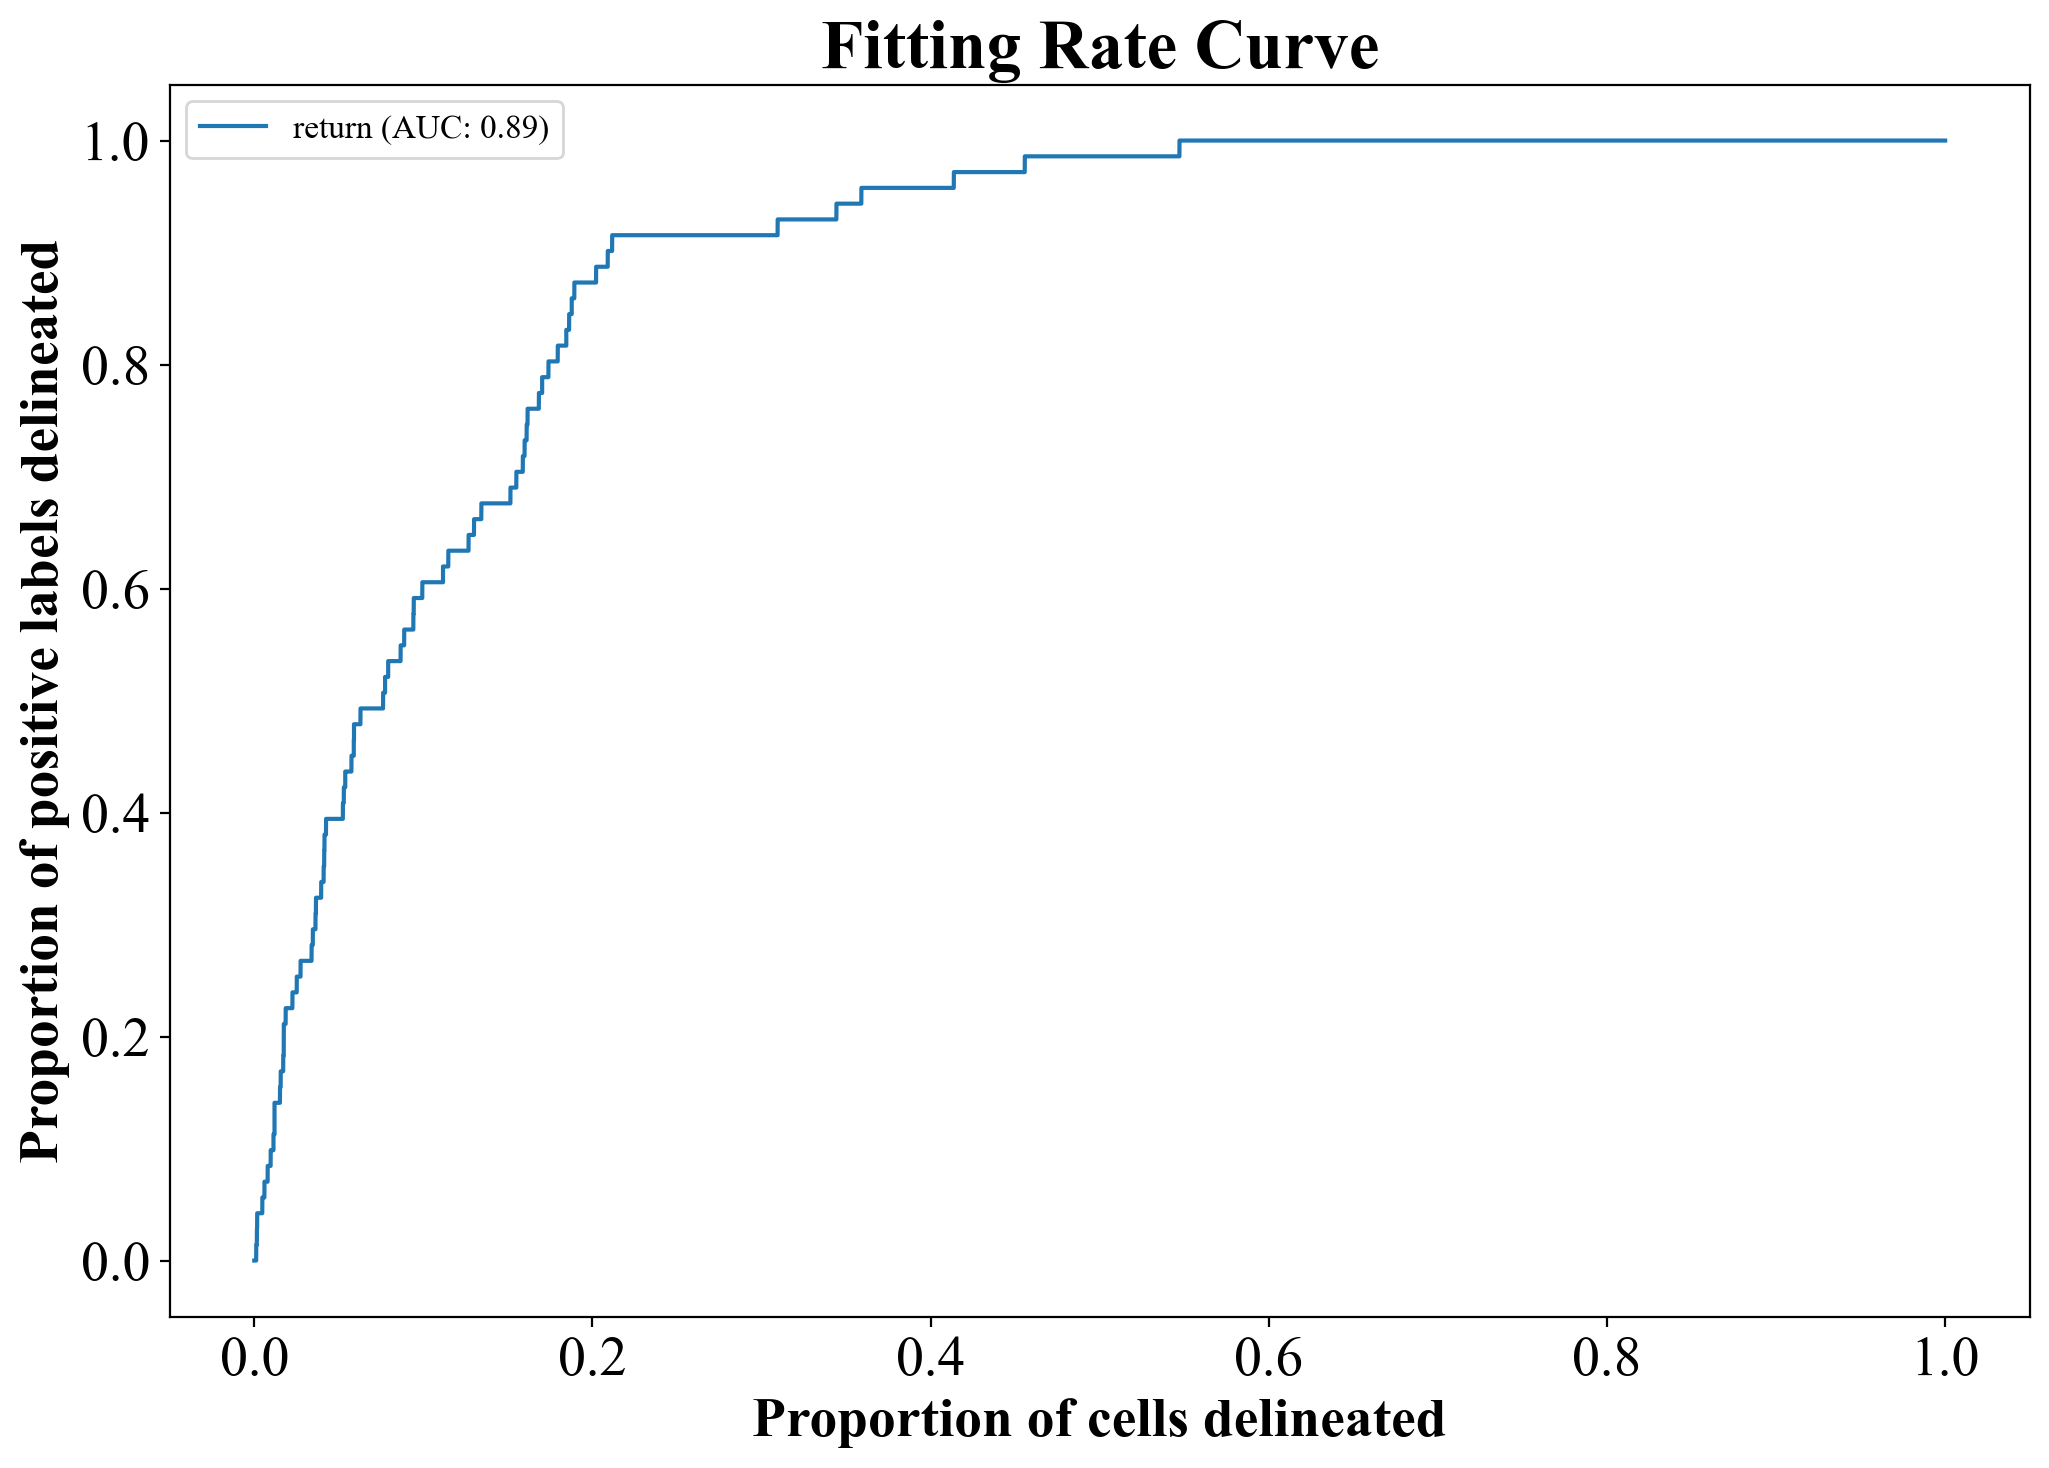

In [42]:
# for multiple predictive models


from scipy.integrate import trapz
import matplotlib.pyplot as plt



plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'




columns = ['return']
df = pd.DataFrame(frate)

plt.figure(figsize=(12, 8), dpi=200)


for col in columns:
    # Sort the DataFrame based on the current column
    df_sorted = df.sort_values(by=col, ascending=False)
    
    # Calculate the Area and Prediction
    df_sorted['Area'] = (df_sorted[col].rank(ascending=False) - 1) / (len(df_sorted) - 1)
    df_sorted['Prediction'] = df_sorted['Target'].cumsum() / df_sorted['Target'].sum()

    # Calculate the area under the curve
    area = trapz(df_sorted['Prediction'], df_sorted['Area'])

    # Plotting the curve for the current column with the area in the label
    plt.plot(df_sorted['Area'], df_sorted['Prediction'], label=f'{col} (AUC: {area:.2f})')



plt.xlabel('Proportion of cells delineated', fontsize=20, fontweight='bold')
plt.ylabel('Proportion of positive labels delineated', fontsize=20, fontweight='bold')
plt.title('Fitting Rate Curve', fontsize=25, fontweight='bold')
plt.legend(fontsize='large')
plt.tick_params(axis='both', which='major', labelsize=20)


# Display the plot
plt.show()



**ROC curve for test data**

In [49]:
FPRC = pd.DataFrame({'FPR': average_fpr})
TPRC=pd.DataFrame({'TPR': average_tpr})

In [51]:
ROCC=pd.DataFrame()
ROCC['FPR']=FPRC['FPR']
ROCC['TPR']=TPRC['TPR']


In [52]:
ROCC

,FPR,TPR
0,0.000000,0.890238
1,0.010101,0.890238
2,0.020202,0.890238
3,0.030303,0.890238
4,0.040404,0.890238
...,...,...
95,0.959596,1.000000
96,0.969697,1.000000
97,0.979798,1.000000
98,0.989899,1.000000


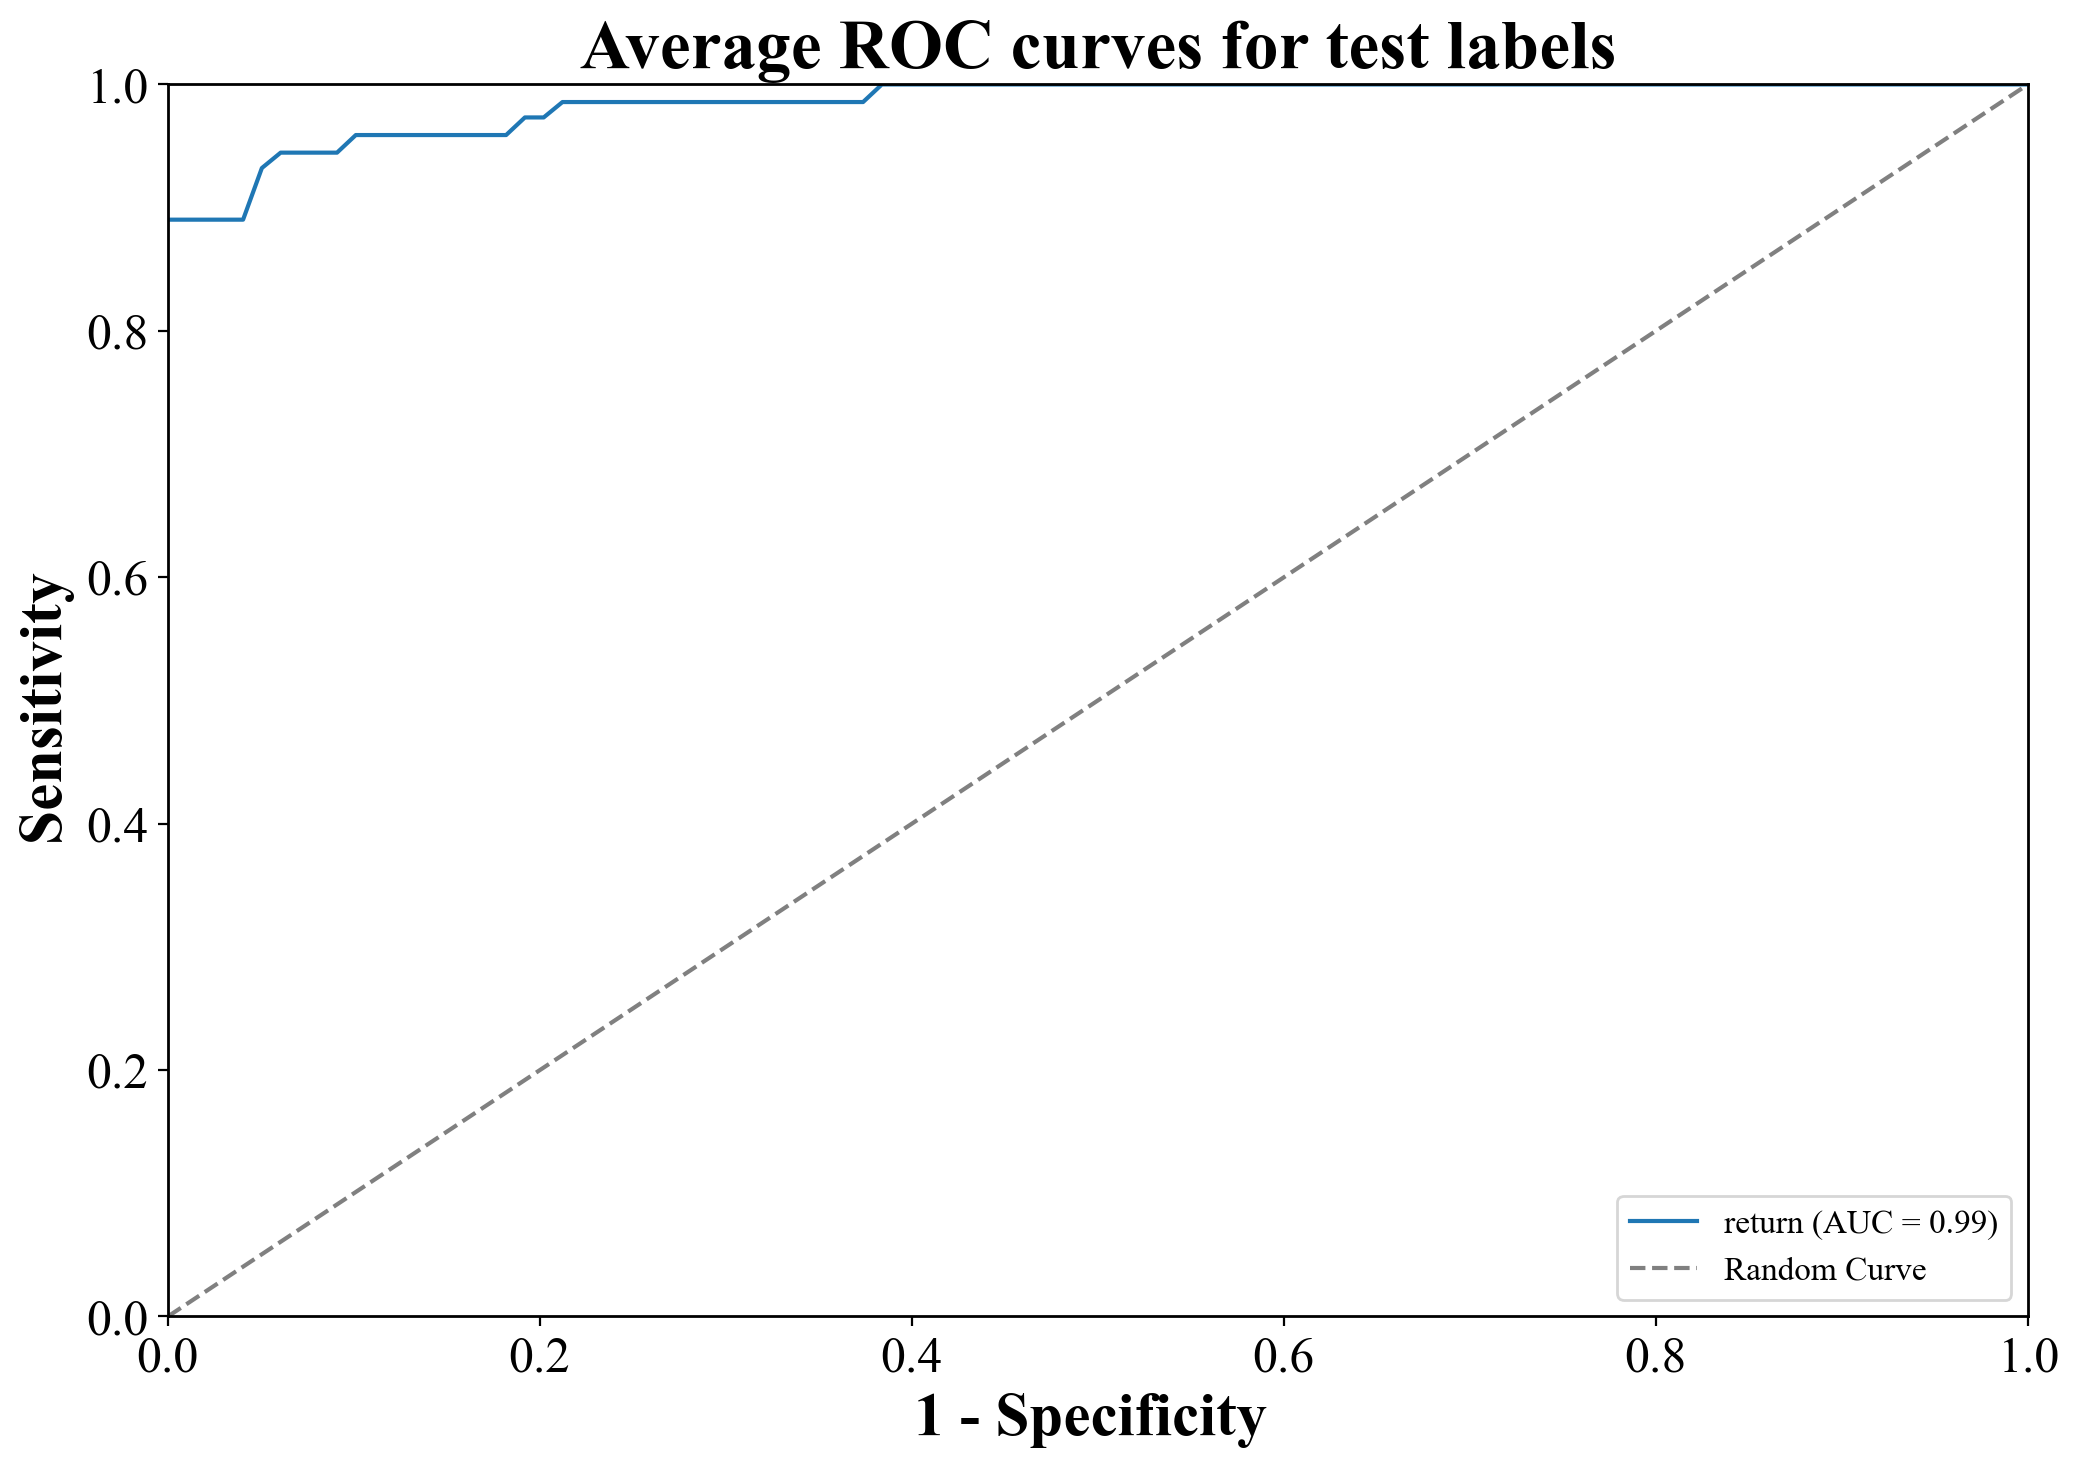

In [54]:
import numpy as np

# Define the pairs of columns and their corresponding titles
column_pairs = [(0, 1, 'return')]

# Create a single plot for all curves
plt.figure(figsize=(12, 8), dpi=200)
plt.title('Average ROC Curves for test data', fontsize=16)

# Initialize a list to store AUC values
auc_values = []

# Loop through pairs of columns and plot them
for col1, col2, title in column_pairs:
    x = ROCC.iloc[:, col1]  # Sensitivity
    y = ROCC.iloc[:, col2]  # Specificity

    # Calculate AUC using the trapezoidal rule (trapz)
    auc = np.trapz(y, x)
    auc_values.append(auc)



    # Plot and add AUC to the legend
    plt.plot(x, y, label=f'{title} (AUC = {auc:.2f})')



plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Curve')




# Adding labels, title, and legend with larger and bold font
plt.xlabel('1 - Specificity ', fontsize=22, fontweight='bold')
plt.ylabel('Sensitivity ', fontsize=22, fontweight='bold')
plt.title('Average ROC curves for test labels', fontsize=25, fontweight='bold')
plt.legend(fontsize='large')
plt.tick_params(axis='both', which='major', labelsize=18)
# Adjusting the axes to start from 0
plt.xlim(0, 1)
plt.ylim(0, 1)



# Making the borders thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1)




# Show the plot
#plt.grid(True)
plt.show()